<a href="https://colab.research.google.com/github/akashchintha/Deep-Learning-Models/blob/master/SqueezeNet_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SqueezeNet - Fashion MNIST

Aim:

1. Implement a [SqueezeNet convolutional neural network](https://arxiv.org/pdf/1602.07360.pdf) architecture.
2. Modify the architecture to use [depthwise seperable convolutions](https://arxiv.org/pdf/1704.04861.pdf) for better on-device performance. 
3. Train your model to classify images of fashion items supplied in the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


## Setup and Data
Code below will import the Fashion MNIST data into a Numpy array using Keras's built in dataset API. Though we use Keras for this step, you are free to use the deep learning framework of your choosing to implement and train your model.

You can read more on the [Fashion MNIST data format here](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles).

In [0]:
# Import the packages we'll need
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Convolution2D, SeparableConv2D, Activation, concatenate, Dropout, warnings
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.models import Model

Using TensorFlow backend.




*   Load the Fashion MNIST data
*   Normalize the image input to restrict it between 0 and 1
*   Add third dimension to the data as it will be needed to manage activation maps in the model





In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train / 255.0

x_test = x_test / 255.0

# Add empty color dimension
x_train = np.expand_dims(x_train, -1)  # shape: (num_samples, 28, 28, 1)
x_test = np.expand_dims(x_test, -1) # shape: (num_samples, 1)

Plot a few examples. 




Note that the images are black and white and that the labels are provided as integer values 0-9.

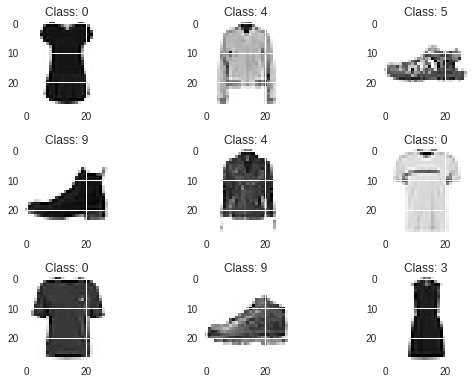

In [0]:
num_examples = 9
indexes = np.random.randint(x_train.shape[0], size=(num_examples))

dim = int(np.sqrt(num_examples))

fig = plt.figure()
k = 1
for idx in indexes:
    ax = fig.add_subplot(dim, dim, k)
    ax.imshow(x_train[idx][:, :, 0])
    ax.set_title('Class: %d' % y_train[idx])
    k += 1
fig.tight_layout()

## Implement and modify SqueezeNet
In this section, you'll implement and modify the SqueezeNet model architecture. SqueezeNet models are neural 50x smaller than the original AlexNet model, but achieve the same performance on ImageNet classification. They're size and runtime performance make them a good choice for computer vision models meant to be used on-device. You can consult the [original paper here](https://arxiv.org/pdf/1602.07360.pdf) as well as open source implementations in various frameworks ([Keras](https://github.com/rcmalli/keras-squeezenet/blob/master/keras_squeezenet/squeezenet.py), [TensorFlow](https://github.com/tensorflow/tpu/blob/master/models/official/squeezenet/squeezenet_model.py#L61), [PyTorch](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)). Again, you do not need to implement this from scratch, but do not simply import these models to use as is, you will need to be able to modify them.

Tasks:

    Implement the most basic configuration of SqueezeNet, specifically the left most column of Figure 2 of the SqueezeNet paper linked above. The model should take a Fashion MNIST image as input and output a vector of probabilities corresponding to the model's confidence that the image belongs to each class.

Note: You may ignore MaxPooling layers given that the dataset provided has very small images (28x28).



In [0]:
# SqueezeNet implementation
def fire_module(x, id, squeeze=16, expand=64):
  s_id = 'fire' + str(id) + '/'
  x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + 'sq1x1')(x)
  x = Activation('relu', name=s_id + 'relu_sq1x1')(x)
 
  left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + 'exp1x1')(x)
  left = Activation('relu', name=s_id + 'relu_exp1x1')(left)
 
  right = Convolution2D(expand, (3, 3), padding='same', name=s_id + 'exp3x3')(x)
  right = Activation('relu', name=s_id + 'relu_exp3x3')(right)
 
  return concatenate([left, right], axis=3, name=s_id + 'concat')
  
  

def build_squeezenet(input_shape=(28, 28, 1), n_classes=10):
  input = Input(shape=input_shape)
  x = Convolution2D(96, (3, 3), strides=(2, 2), padding='valid', name='conv1')(input)
  x = Activation('relu', name='relu_conv1')(x)

  x = fire_module(x, id=2, squeeze=16, expand=128)
  x = fire_module(x, id=3, squeeze=16, expand=128)

  x = fire_module(x, id=4, squeeze=32, expand=256)
  x = fire_module(x, id=5, squeeze=32, expand=256)

  x = fire_module(x, id=6, squeeze=48, expand=384)
  x = fire_module(x, id=7, squeeze=48, expand=384)
  x = fire_module(x, id=8, squeeze=64, expand=512)
  x = fire_module(x, id=9, squeeze=64, expand=512)
  x = Dropout(0.5, name='drop')(x)

  x = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(x)
  x = Activation('relu', name='relu_conv10')(x)
  x = GlobalAveragePooling2D()(x)
  out = Activation('softmax', name='softmax')(x)

  model = Model(input, out, name='squeezenet')
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  print(model.summary())
  return model

    Modify the SqueezeNet architecture to use Depthwise Seperable convolutions instead of regular convolutions for better runtime performance. 

Note: You should include Batch Normalization layers after depthwise seperable convolution layers and before RELU activation layers to improve training.

In [0]:
# Squeezenet with Depthwise Convolutions
def fire_module_depthwise(x, id, squeeze=16, expand=64):
  s_id = 'fire' + str(id) + '/'
  x = SeparableConv2D(squeeze, (1, 1), padding='valid', name=s_id + 'sq1x1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu', name=s_id + 'relu_sq1x1')(x)
 
  left = SeparableConv2D(expand, (1, 1), padding='valid', name=s_id + 'exp1x1')(x)
  left = BatchNormalization()(left)
  left = Activation('relu', name=s_id + 'relu_exp1x1')(left)
 
  right = SeparableConv2D(expand, (3, 3), padding='same', name=s_id + 'exp3x3')(x)
  right = BatchNormalization()(right)
  right = Activation('relu', name=s_id + 'relu_exp3x3')(right)
 
  return concatenate([left, right], axis=3, name=s_id + 'concat')



def build_squeezenet_depthwise(input_shape=(28, 28, 1), n_classes=10):
  input = Input(shape=input_shape)
  x = SeparableConv2D(96, (3, 3), strides=(2, 2), padding='valid', name='conv1')(input)
  x = BatchNormalization()(x)
  x = Activation('relu', name='relu_conv1')(x)

  x = fire_module_depthwise(x, id=2, squeeze=16, expand=128)
  x = fire_module_depthwise(x, id=3, squeeze=16, expand=128)

  x = fire_module_depthwise(x, id=4, squeeze=32, expand=256)
  x = fire_module_depthwise(x, id=5, squeeze=32, expand=256)

  x = fire_module_depthwise(x, id=6, squeeze=48, expand=384)
  x = fire_module_depthwise(x, id=7, squeeze=48, expand=384)
  x = fire_module_depthwise(x, id=8, squeeze=64, expand=512)
  x = fire_module_depthwise(x, id=9, squeeze=64, expand=512)
  x = Dropout(0.5, name='drop')(x)

  x = SeparableConv2D(n_classes, (1, 1), padding='valid', name='conv10')(x)
  x = BatchNormalization()(x)
  x = Activation('relu', name='relu_conv10')(x)
  x = GlobalAveragePooling2D()(x)
  out = Activation('softmax', name='softmax')(x)

  model = Model(input, out, name='squeezenet')
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  print(model.summary())
  return model

Initialize models for both the architectures.

Summary for both the models are printed out during initialization.

***SqueezeNet*** - Total params: 1,451,786

***SqueezeNet (with depthwise convolution)*** - Total params: 498,587

In [0]:
model = build_squeezenet()
model_dw = build_squeezenet_depthwise()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 13, 13, 96)   960         input_3[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 13, 13, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2/sq1x1 (Conv2D)            (None, 13, 13, 16)   1552        relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/relu

## Train your models

Train the models implemented above. You should be able to achieve an accuracy of above 85% with both architectures. Do not worry about achieving the highest accuracy, we are primarily interested in proof that the model is training properly.

**SQUEEZENET**

In [0]:
# Your training code goes here
print('Model: SqueezeNet')
model.fit(x_train, y_train, epochs = 5, validation_split = 0.15)
score, accuracy = model.evaluate(x_test, y_test)
print('The testing accuracy for SqueezeNet is {}'.format(accuracy))

Model: SqueezeNet
Train on 51000 samples, validate on 9000 samples
Epoch 1/5
51000/51000 [==============================] - 142s 3ms/step - loss: 1.0388 - acc: 0.6167 - val_loss: 0.5505 - val_acc: 0.7994
Epoch 2/5
51000/51000 [==============================] - 137s 3ms/step - loss: 0.4980 - acc: 0.8195 - val_loss: 0.4456 - val_acc: 0.8378
Epoch 3/5
51000/51000 [==============================] - 137s 3ms/step - loss: 0.4286 - acc: 0.8425 - val_loss: 0.3888 - val_acc: 0.8549
Epoch 4/5
51000/51000 [==============================] - 137s 3ms/step - loss: 0.3874 - acc: 0.8566 - val_loss: 0.4153 - val_acc: 0.8419
Epoch 5/5
10000/10000 [==============================] - 7s 725us/step
The testing accuracy for SqueezeNet is 0.8539


**SQUEEZENET with depthwise convolutions and batchnorm**

In [0]:
print('Model: SqueezeNet with Depthwise Convolutions')
model_dw.fit(x_train, y_train, epochs = 5, validation_split = 0.15)
score_dw, accuracy_dw = model_dw.evaluate(x_test, y_test)
print('The testing accuracy for SqueezeNet with depthwise convolutions is {}'.format(accuracy_dw))

Model: SqueezeNet with Depthwise Convolutions
Train on 51000 samples, validate on 9000 samples
Epoch 1/5
51000/51000 [==============================] - 174s 3ms/step - loss: 0.7958 - acc: 0.7842 - val_loss: 0.4968 - val_acc: 0.8393
Epoch 2/5
51000/51000 [==============================] - 167s 3ms/step - loss: 0.4887 - acc: 0.8488 - val_loss: 0.5150 - val_acc: 0.8230
Epoch 3/5
51000/51000 [==============================] - 167s 3ms/step - loss: 0.4081 - acc: 0.8678 - val_loss: 0.3340 - val_acc: 0.8847
Epoch 4/5
51000/51000 [==============================] - 167s 3ms/step - loss: 0.3639 - acc: 0.8780 - val_loss: 0.4105 - val_acc: 0.8662
Epoch 5/5
10000/10000 [==============================] - 9s 938us/step
The testing accuracy for SqueezeNet with depthwise convolutions is 0.8769


In [0]:
scores = model.predict(x_test)
scores_dw = model_dw.predict(x_test)

 Checking if the prediction from SqueezeNet matches the ground truth

In [0]:
#
np.argmax(scores[2]) == y_test[2]

True

Checking if the prediction from SqueezeNet (with depthwise convolution and batchnorm) matches the ground truth

In [0]:
# 
np.argmax(scores_dw[2]) == y_test[2]

True

## Summary

It is evident from the evaluation that the depthwise convolutional network performs better and at higher speed compared to the traditional convolutional layers and contains only about one-thirds of parameters to learn.

Feel free to tweak the hyperparameters and also the model. Observe how each of the changes affects the performance.